In [1]:
import ot
import torch
from data_gen_1D import Generator
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.offsetbox import AnchoredText

import time

In [2]:
# This function evaluates the Wasserstein distance between two 1D distributions, 'a' and 'b,' with weights 'wa' and 'wb.'
# The parameter 'p' defines which Wasserstein distance is calculated. For 'p=1,' the result is the 1-Wasserstein distance, and for 'p=2,' the output is the 2-Wasserstein distance.

def wasserstein_distance(a, b, wa, wb):
        
    W_dist = ot.wasserstein_1d(a, b, wa, wb, p = 1)

    return W_dist

In [3]:
# This funciton evaluetes the Z_score.

def Z_score(H0, t1):
    
    if t1 <= torch.max(H0):
        p_value = (torch.count_nonzero(H0 >= t1) + 1)/(torch.tensor(H0.size()) + 1)

    if t1 > torch.max(H0):
        p_value = 1/(torch.tensor(H0.size()) + 1)
        
    return torch.tensor(norm.ppf(1-p_value))

In [4]:
# This function plots and saves the distributions of the Wasserstein distances and prints the Z_score on the plot.

def Plotter(W_dist_calibration, W_dist, color, label, save):

    fig, ax = plt.subplots(1, 1, figsize = (7, 7))

    ax.set_title('Wasserstein distance', fontsize = 20)
    ax.set_xlabel('$W_{1}$', fontsize = 15)
    ax.set_ylabel('Density', fontsize = 15)

    z_score = Z_score(W_dist_calibration, torch.median(W_dist))
    anchored_text_test = AnchoredText('$Z_{score}$:'+str('%.3f' % z_score.item()), bbox_to_anchor = (1, 0.85), bbox_transform = ax.transAxes, loc = 'right')

    ax.hist(W_dist_calibration, bins = 'auto', color = color[0], density = True, label = 'ref-'+str(label[0]), alpha = 0.5)
    ax.hist(W_dist, bins = 'auto', color = color[1], density = True, label = 'ref-'+str(label[1]), alpha = 0.5)
    ax.legend()

    ax.add_artist(anchored_text_test)

    if save:

        fig.savefig(f'./LPC_Plot/W_dist_{label}.pdf')



Computational time: 4.635724782943726 s


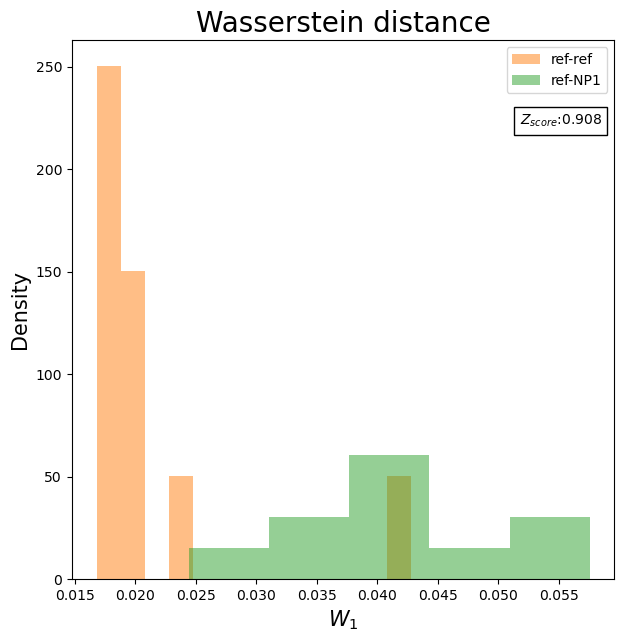

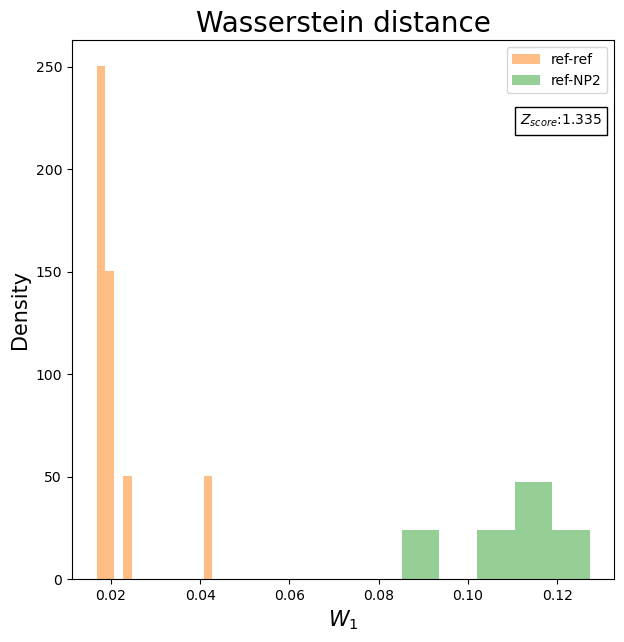

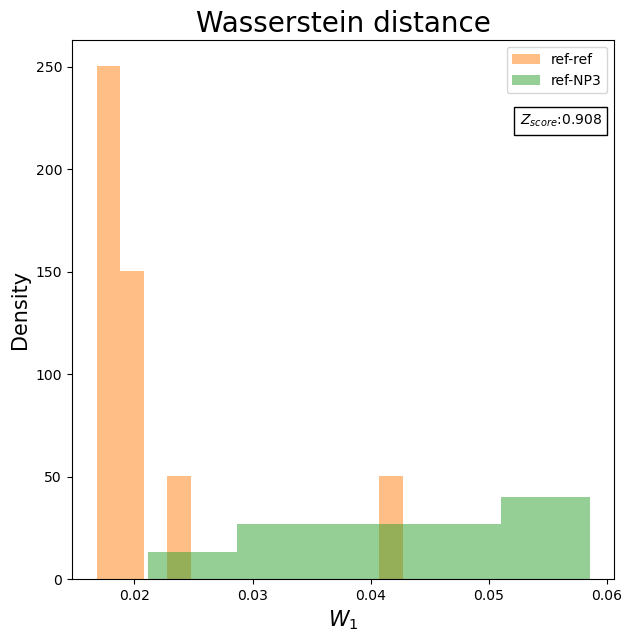

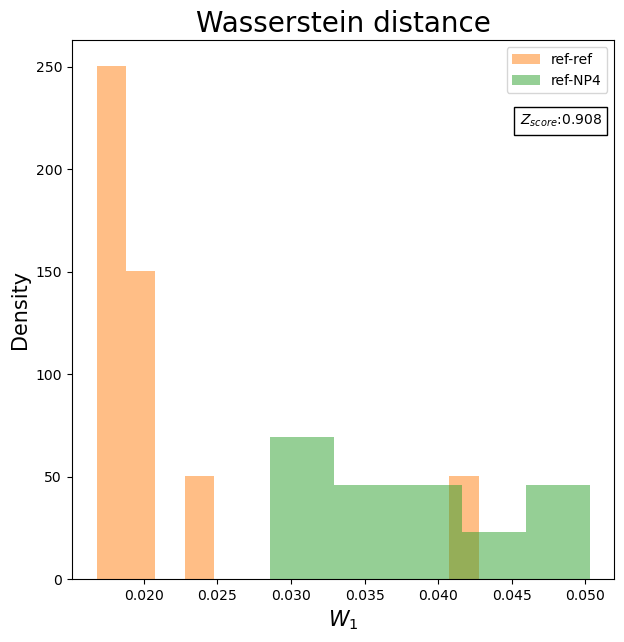

In [8]:
iteration = 1000

# Number of signal events.
NS = 0
# Size of background sample.
NR = 2000

# Size of reference sample.
N_R = 200000

# Here, I define the tensors where I will store the results.
W_dist_calibration = torch.zeros(iteration)
W_dist = torch.zeros(iteration)

# These are the different classes.
classes = ['NP1', 'NP2', 'NP3', 'NP4']

# This array represents the values of 'NS' and 'NR' for the different classes.
values = [[10, 1990], [110, 1890], [80, 1920], [0, 2000]]

# This parameter defines whether to save the plots or not.
save = True
Pois_ON = False

st = time.time()
l = 0

for sig_type in classes:
    
    for seed in range(iteration):

        # Here, I generate two samples using the Generator and then evaluete the Wasserstein distance. In this case the samples belong to the same class 'ref'.
        ref, data = Generator(seed, NS, NR, N_R, 'ref', Pois_ON)
        W_dist_calibration[seed] = wasserstein_distance(torch.squeeze(ref), torch.squeeze(data), torch.tensor(1/ref.size(0)), torch.tensor(1/data.size(0)))

        # Here, I generate two new samples using the Generator and then evaluete the Wasserstein distance. In this case the forst sample belongs to the class 'ref' and the second to the class sig_type.
        ref, data_true  = Generator(seed + int(1e6), values[l][0], values[l][1], N_R, sig_type, Pois_ON)
        W_dist[seed] = wasserstein_distance(torch.squeeze(ref), torch.squeeze(data_true), torch.tensor(1/ref.size(0)), torch.tensor(1/data_true.size(0)))
    
    Plotter(W_dist_calibration, W_dist, ['#ff7f0e', '#2ca02c'], ['ref', sig_type], save)
    l = l+1

et = time.time()

print(f'Computational time: {et-st} s')